In [1]:
import hydra
from omegaconf import DictConfig, OmegaConf

In [2]:
cfg = OmegaConf.load("conf/dataset/test.yaml")

In [3]:
cfg.dataset.augmentations

[{'_target_': 'torchvision.transforms.RandomRotation', 'degrees': {'type': 'random', 'args': 30}}, {'_target_': 'torchvision.transforms.RandomHorizontalFlip', 'p': {'type': 'explicit', 'args': [0.0, 1.0]}}, {'_target_': 'torchvision.transforms.RandomVerticalFlip', 'p': {'type': 'explicit', 'args': [0.0, 1.0]}}]

In [4]:
# @hydra.main(version_base=None, config_path="conf", config_name="config")

In [5]:
from src.dataset.transforms import AugmentationPipeline

In [6]:
a = AugmentationPipeline(cfg.dataset.augmentations)

In [7]:
a.explicit_grid

[{1: {'p': 0.0}, 2: {'p': 0.0}},
 {1: {'p': 0.0}, 2: {'p': 1.0}},
 {1: {'p': 1.0}, 2: {'p': 0.0}},
 {1: {'p': 1.0}, 2: {'p': 1.0}}]

In [8]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.transforms import functional as t_F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import hydra
from omegaconf import DictConfig, OmegaConf
from src.dataset.transforms import AugmentationPipeline
from src.dataset.main_dataset import MainCachedDataset, Imputation

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["TORCH_HOME"] = "D:\Yasin\.checkpoints"
data_root = 'D:\Data'

In [10]:
train_df = pd.read_excel(os.path.join(data_root, 'Meta/train_main_features_75.xlsx'), keep_default_na=False, na_values=[""], dtype = str)
test_df = pd.read_excel(os.path.join(data_root, 'Meta/test_main_features_75.xlsx'), keep_default_na=False, na_values=[""], dtype = str)
train_hpv = pd.read_excel(os.path.join(data_root, 'Meta/train_HPV_features_75.xlsx'),)
test_hpv = pd.read_excel(os.path.join(data_root, 'Meta/test_HPV_features_75.xlsx'),)

In [11]:
train_df.head()

,Patient ID,jpg_file,xlsx_file,Date,Adeno:conclusive,AA:Color,AA:Margin of aceto acid,AA:Surface,AA:Size,Vessels:Punctuation,...,EXTRA INFO,Age,Smoking,Drink,SD,Married,#Partner,Pop,Abnormality(Impression),Abnormality(BX)
0,14.976,14.976/14_976_A.TIF,14.976.xlsx,1403.03,NO,Snowy White,Geographical,Flat,Small,Fine,...,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,True,True
1,19.202,19.202/19_202_A.JPG,19.202.xlsx,1404.02,No,Snowy White,Geographical,Flat,Small,Fine,...,NaN,40,Yes,Yes,NaN,No,4,NaN,True,True
2,19.503,19_503/19_503_A4.JPG,19.503.xlsx,NaN,No,Snowy White,Geographical,Flat,Large,Fine,...,NaN,42,No,No,27,Yes,1,NaN,True,True
3,17.282,17_282/17_282_A3.TIF,17.282.xlsx,1402.12,Yes,Pink,None,None,None,None,...,NaN,38,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,17.590,17_590/17_590_A1.JPG,17.590.xlsx,1403.03,Yes,Pink,None,None,None,None,...,NaN,45,No,No,NaN,Yes,NaN,NaN,False,False


In [22]:
# img = Image.open(os.path.join(data_root, "Cropped Folder", train_df['Patient ID'][0], train_df['jpg_file'][0]))
# img

In [20]:
# b = a(img, 2)
# b

In [23]:
train_df.loc[train_df['Logul'] == 'Negetive', 'Logul'] = 'Negative'
train_df.loc[train_df['Logul'] == 'POSITIVE', 'Logul'] = 'Positive'
test_df.loc[test_df['Logul'] == 'Negetive', 'Logul'] = 'Negative'
test_df.loc[test_df['Logul'] == 'POSITIVE', 'Logul'] = 'Positive'

In [24]:
HPV_col = ['16', '18', 'Others', "No"]
def prepare_hpv(df):
    hpv_df = pd.DataFrame(data= np.array([[0]*len(HPV_col)]*len(df)) , columns=HPV_col)
    hpv_df.iloc[df['16'].isna()] = np.nan
    hpv_df['16'] = df['16']
    hpv_df['18'] = df['18']
    others = df.drop(columns=['16', '18']).sum(axis=1, skipna = False)
    hpv_df.loc[others.notna() & others.astype(bool), 'Others'] = 1
    pos = df.sum(axis=1, skipna = False)
    pos_flag = pos.astype(bool) & df['16'].notna()
    hpv_df.loc[pos.notna() & ~pos_flag, 'No'] = 1
    return hpv_df

In [25]:
train_hpv = prepare_hpv(train_hpv)
test_hpv = prepare_hpv(test_hpv)

In [26]:
extra_train_df = pd.concat([train_df['Age'],train_df['Logul'],train_df['Pop'], train_hpv], axis = 1)
extra_test_df = pd.concat([test_df['Age'],test_df['Logul'],test_df['Pop'], test_hpv], axis = 1)

extra_train_df["Age"] = pd.to_numeric(extra_train_df["Age"], errors="coerce").astype("Int64")
extra_test_df["Age"] = pd.to_numeric(extra_test_df["Age"], errors="coerce").astype("Int64")

In [27]:
extra_test_df.head()

,Age,Logul,Pop,16,18,Others,No
0,31,Positive,NILM,0.0,0.0,0.0,1.0
1,40,Negative,NILM,1.0,0.0,0.0,0.0
2,42,Positive,HSIL,1.0,0.0,0.0,0.0
3,30,Positive,NILM,0.0,1.0,1.0,0.0
4,41,Negative,NaN,NaN,NaN,NaN,NaN


In [28]:
imp = Imputation()
X_train_tab = imp.fit_transform(extra_train_df)
X_test_tab = imp.transform(extra_test_df)

In [29]:
train_df = pd.concat([train_df[['Patient ID', 'jpg_file', 'Abnormality(Impression)', 'Abnormality(BX)']], X_train_tab], axis = 1)
test_df = pd.concat([test_df[['Patient ID', 'jpg_file', 'Abnormality(Impression)', 'Abnormality(BX)']], X_test_tab], axis = 1)

In [30]:
test_df.head()

,Patient ID,jpg_file,Abnormality(Impression),Abnormality(BX),Age,HPV_encoded,Pap_level,Pap_missing,Lugol
0,18.602,18_602/18_602_A1.JPG,True,True,-0.451529,-2.0,0.0,0.0,1.0
1,18.617,18_617/18_617_A1.JPG,False,False,0.728641,2.5,0.0,0.0,-1.0
2,17.94,17_94/17_94_A2.TIF,True,True,0.990901,2.5,4.0,0.0,1.0
3,19.663,19.663/19_663_A2.JPG,True,False,-0.582659,2.0,0.0,0.0,1.0
4,19.154,19.154/19_154_A2.JPG,True,True,0.859771,0.0,0.0,1.0,-1.0


In [37]:
cfg = OmegaConf.load("conf/dataset/test.yaml")
base_pipeline = AugmentationPipeline(cfg.dataset.base_pipeline)
aug_pipeline = AugmentationPipeline(cfg.dataset.augmentations)

In [38]:
test_dataset = MainCachedDataset(test_df, 
                                 image_root= cfg.dataset.image_root, 
                                 aug_mode = cfg.dataset.aug_mode, 
                                 label_col = cfg.dataset.label_col, 
                                 include_original = cfg.dataset.include_original, 
                                 num_random_augs = cfg.dataset.num_random_augs, 
                                 base_pipeline= base_pipeline, 
                                 aug_pipeline = aug_pipeline)

[MainCachedDataset] Mode: fully_cached | Images: 106 | Explicit variants/image: 4 | Include original: True | Total samples: 1378


In [40]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

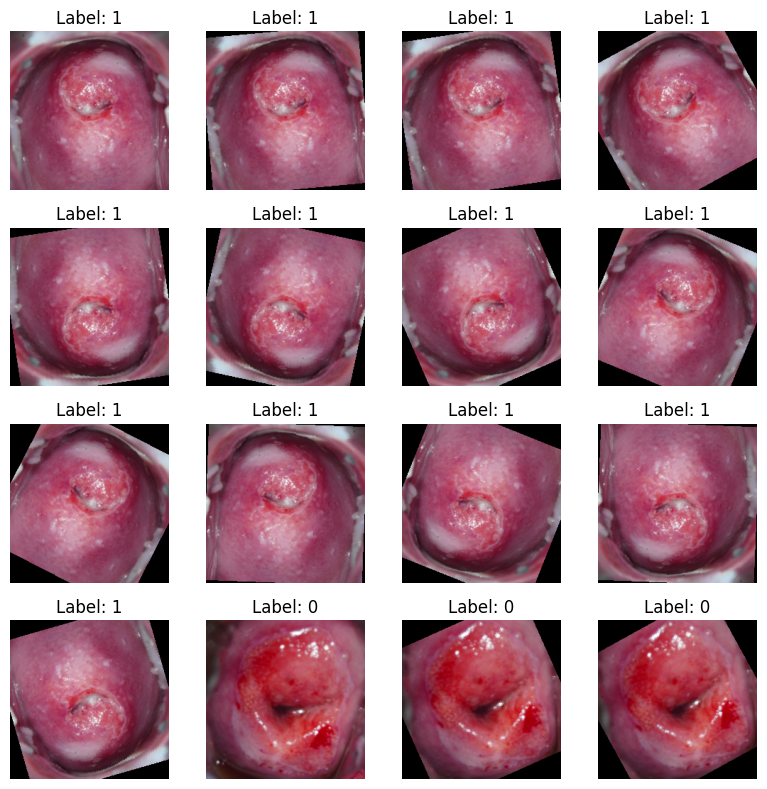

In [41]:
import matplotlib.pyplot as plt

def show_all_augmentations(dataset, img_idx):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        img, _, _ = dataset[img_idx * 16 + i]
        axes[i // 4, i % 4].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i // 4, i % 4].axis('off')
    plt.show()

def show_first_16_from_batch(batch):
    images, labels = batch

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(16):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        label = labels[i].item()

        axes[i // 4, i % 4].imshow(img)
        axes[i // 4, i % 4].set_title(f"Label: {label}")
        axes[i // 4, i % 4].axis("off")

    plt.tight_layout()
    plt.show()

# show_all_augmentations(train_dataset, 0)
batch = next(iter(test_loader))
show_first_16_from_batch(batch)


In [ ]:
img = Image.open(os.path.join(data_root, r'Cropped Folder/19.202', r'19.202/19_202_A.JPG'))

In [ ]:
out = a(img, 0)

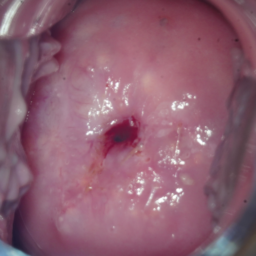

In [ ]:
out

In [ ]:
import pandas as pd
a = pd.DataFrame([[1,2],[3,4]], columns= ['a', 'b'])

In [ ]:
type(a)

pandas.core.frame.DataFrame

In [ ]:
a = {1:2}
a[2]

KeyError: 2